# Monte-carlo Tree Search


In this notebook, we'll implement a MCTS planning and use it to solve a Gym env.

![image.png](https://i.postimg.cc/6QmwnjPS/image.png)

__How it works?__
We just start with an empty tree and expand it. There are several common procedures.

__1) Selection__
Starting from the root, recursively select the node that corresponds to the tree policy.  

There are several options for tree policies, which we saw earlier as exploration strategies: epsilon-greedy, Thomson sampling, UCB-1. It was shown that in MCTS, UCB-1 achieves a good result. Further, we will consider the one, but you can try to use others.

Following the UCB-1 tree policy, we will choose an action that, on one hand, we expect to have the highest return, and on the other hand, we haven't explored much.

$$
\DeclareMathOperator*{\argmax}{arg\,max}
$$

$$
\dot{a} = \argmax_{a} \dot{Q}(s, a)
$$

$$
\dot{Q}(s, a) = Q(s, a) + C_p \sqrt{\frac{2 \log {N}}{n_a}}
$$

where: 
- $N$ - number of times we have visited state $s$,
- $n_a$ - number of times we have taken action $a$,
- $C_p$ - exploration balance parameter, which is performed between exploration and exploitation. 

Using Hoeffding inequality for rewards $R \in [0,1]$ it can be shown that optimal $C_p = 1/\sqrt{2}$. For rewards outside this range, the parameter should be tuned. We'll be using 10, but you can experiment with other values.

__2) Expansion__
After the selection procedure, we can achieve a leaf node or node in which we don't complete actions. In this case, we expand the tree by feasible actions and get new state nodes. 

__3) Simulation__
How we can estimate node Q-values? The idea is to estimate action values for a given _rollout policy_ by averaging the return of many simulated trajectories from the current node. Simply, we can play with random or some special policy or use some model that can estimate it.

__4) Backpropagation__
The reward of the last simulation is backed up through the traversed nodes and propagates Q-value estimations, upwards to the root.

$$
Q({\text{parent}}, a) = r + \gamma \cdot Q({\text{child}}, a)
$$

In [1]:
!pip install setuptools==65.5.0
!pip install gym==0.21.0
!pip install pyglet==1.5.11
!apt install xvfb -y
!pip install pyvirtualdisplay
!apt-get install python-opengl -y

from pyvirtualdisplay import Display
Display().start()
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.1 requires setuptools>65.5.1, but you have setuptools 65.5.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ 

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import gym
from gym.core import Wrapper
from pickle import dumps, loads
from collections import namedtuple


We first need to make a wrapper for Gym environments to allow saving and loading game states to facilitate backtracking.

In [4]:
ActionResult = namedtuple(
    "action_result", ("snapshot", "observation", "reward", "is_done", "info"))


class WithSnapshots(Wrapper):
    # Creates a wrapper that supports saving and loading environemnt states.
    # Required for planning algorithms.


    def get_snapshot(self, render=False):
        # returns environment state that can be loaded with load_snapshot.
        
        
        if render:
            self.render()  
            self.close()
            
        # if self.unwrapped.viewer is not None:
        #     self.unwrapped.viewer.close()
        #     self.unwrapped.viewer = None
        return dumps(self.env)
    
           
    def load_snapshot(self, snapshot, render=False):
        # loads snapshot as current env state.
        
        assert not hasattr(self, "_monitor") or hasattr(
            self.env, "_monitor"), "can't backtrack while recording"

        if render:
            self.render()  
            self.close()
        self.env = loads(snapshot)
        

    def get_result(self, snapshot, action):
        # Breturns next snapshot and everything that env.step would have returned.
        
        self.load_snapshot(snapshot, render=False)
        next_observation, reward, is_done, info = self.step(action)
        next_snapshot = self.get_snapshot()
        return ActionResult(next_snapshot, next_observation, reward, is_done, info)

### Try out snapshots

In [5]:
# make env
env = WithSnapshots(gym.make("CartPole-v0"))
env.reset()

n_actions = env.action_space.n

initial_state:


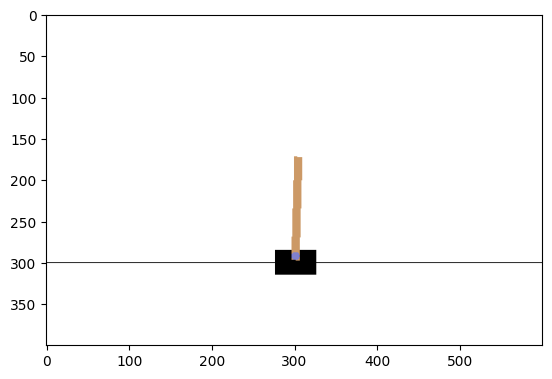

In [6]:
print("initial_state:")
plt.imshow(env.render('rgb_array'))
env.close()

# create first snapshot
snap0 = env.get_snapshot()

Whoops! We died!
final state:


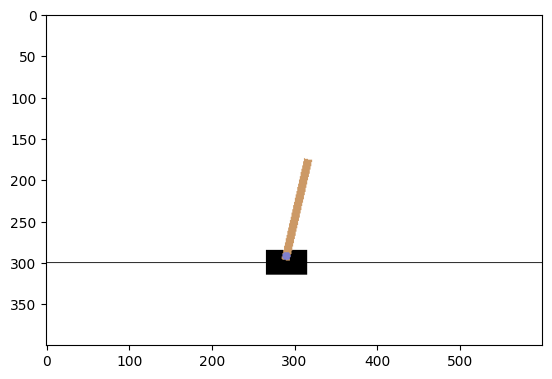

In [7]:
# play without making snapshots (faster)
while True:
    is_done = env.step(env.action_space.sample())[2]
    if is_done:
        print("Whoops! We died!")
        break

print("final state:")
plt.imshow(env.render('rgb_array'))
env.close()



After loading snapshot


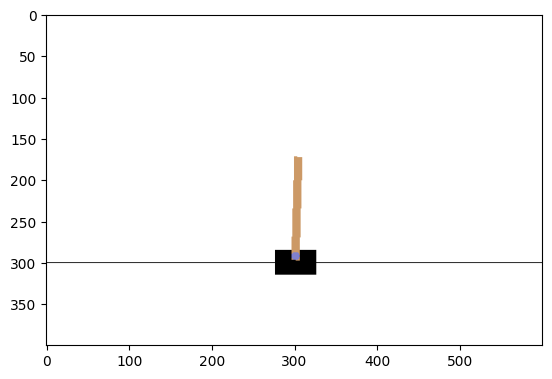

In [8]:
# reload initial state
env.load_snapshot(snap0)

print("\n\nAfter loading snapshot")
plt.imshow(env.render('rgb_array'))
env.close()

In [9]:
# get outcome (snapshot, observation, reward, is_done, info)
res = env.get_result(snap0, env.action_space.sample())

snap1, observation, reward = res[:3]

# second step
res2 = env.get_result(snap1, env.action_space.sample())

# MCTS: Monte-Carlo Tree Search


Implementing the `Node` class - a simple class that acts like MCTS node and supports some of the MCTS algorithm steps.

This MCTS implementation makes some assumptions about the environment, you can find those _in the notes section at the end of the notebook_.

In [10]:
assert isinstance(env, WithSnapshots)

In [11]:
class Node:
    # a tree node for MCTS.
    
    parent = None  # parent Node
    qvalue_sum = 0.  # sum of Q-values from all visits 
    times_visited = 0  # counter of visits 

    
    def __init__(self, parent, action):
        # Creates and empty node with no children.
        
        self.parent = parent
        self.action = action
        self.children = set()  # set of child nodes

        # get action outcome and save it
        res = env.get_result(parent.snapshot, action)
        self.snapshot, self.observation, self.immediate_reward, self.is_done, _ = res
        

        
    def is_leaf(self):
        return len(self.children) == 0
    
    

    def is_root(self):
        return self.parent is None
    
    

    def get_qvalue_estimate(self):
        return self.qvalue_sum / self.times_visited if self.times_visited != 0 else 0
    

    
    def ucb_score(self, scale=10, max_value=1e100):
        # param scale: Multiplies upper bound by that. From Hoeffding inequality, assumes reward range to be [0, scale].
        # param max_value: a value that represents infinity (for unvisited nodes).

        if self.times_visited == 0:
            return max_value
        return self.qvalue_sum + scale * np.sqrt(2*np.log(self.parent.times_visited)/self.times_visited)

        # ==================================== Your Code (Begin) ==================================
        
        # calculate and return UCB-1 score
        
        # ==================================== Your Code (End) ====================================

        
        
        
    
    def select_best_leaf(self):
        max_ucb = -10000
        chosen_child = None
        for child in self.children:
            if child.ucb_score()>max_ucb:
                chosen_child = child
                max_ucb = child.ucb_score()
        if chosen_child.is_leaf():
            return chosen_child 
        else:
            return chosen_child.select_best_leaf()        
        # ==================================== Your Code (Begin) ==================================
        
        # return the leaf with the highest priority to expand.
        # hint: recursively pick nodes with the best UCB-1 score until it reaches a leaf.
        
        # ==================================== Your Code (End) ====================================

        
        
        

    def expand(self):
        # expands the current node by creating all possible child nodes.
        # returns one of those children.
        
        assert not self.is_done, "can't expand from terminal state"

        for action in range(n_actions):
            self.children.add(Node(self, action))

        return self.select_best_leaf()
    
    

    def rollout(self, t_max=10**4):
        
        # set env into the appropriate state
        env.load_snapshot(self.snapshot)
        obs = self.observation
        is_done = self.is_done
        if is_done:
            return 0
        i = 0
        rollout_reward = 0
        while i<t_max:
            random_action = env.action_space.sample()
            new_obs, reward, done, info = env.step(random_action)
            rollout_reward += reward
            if done:
                break
            i += 1
        return rollout_reward

        # ==================================== Your Code (Begin) ==================================
        
        
        # Play the game from this state to the end (done) or for t_max steps.
        # On each step, pick action at random (hint: env.action_space.sample()).
        
        # Compute sum of rewards from current state till 
        # Note 1: use env.action_space.sample() for random action
        # Note 2: if node is terminal (self.is_done is True), just return 0
        
        
        # return rollout_reward  

        
        # ==================================== Your Code (End) ====================================


        
        
        
        
    def propagate(self, child_qvalue):
        # Uses child Q-value (sum of rewards) to update parents recursively.
        
        # compute node Q-value
        my_qvalue = self.immediate_reward + child_qvalue

        # update qvalue_sum and times_visited
        self.qvalue_sum += my_qvalue
        self.times_visited += 1

        # propagate upwards
        if not self.is_root():
            self.parent.propagate(my_qvalue)

            
            
    def safe_delete(self):
        # safe delete to prevent memory leak in some python versions 
        del self.parent
        for child in self.children:
            child.safe_delete()
            del child

In [12]:
class Root(Node):
    def __init__(self, snapshot, observation):
        # creates special node that acts like tree root
        
        self.parent = self.action = None
        self.children = set()  # set of child nodes

        # root: load snapshot and observation
        self.snapshot = snapshot
        self.observation = observation
        self.immediate_reward = 0
        self.is_done = False

    @staticmethod
    def from_node(node):
        # initializes node as root
        root = Root(node.snapshot, node.observation)
        # copy data
        copied_fields = ["qvalue_sum", "times_visited", "children", "is_done"]
        for field in copied_fields:
            setattr(root, field, getattr(node, field))
        return root

## Main MCTS Loop


In [13]:
def plan_mcts(root, n_iters=10):
    root.expand()
    
    # build tree with monte-carlo tree search for n_iters iterations
    for i in range(n_iters):
        node = root.select_best_leaf()
        if node.is_done:
            node.propagate(node.immediate_reward)
        else:
            node.expand()
            reward = node.rollout()
            node.propagate(reward)

    # ==================================== Your Code (Begin) ==================================
    
    # Hint: for n_iters: select best leaf, expand it, perform a rollout from it, propagate the results upwards.
    # Note: don't forget to check the is_done condition in the loop
    
    # ==================================== Your Code (End) ====================================

## Plan and execute

Here we use our MCTS implementation to find the optimal policy.

In [17]:
import IPython
import imageio
import base64
def embed_mp4(filename):
  
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    
    return IPython.display.HTML(tag)

def create_video(frames, filename='output'):
  
    filename = filename + ".mp4"
    fps  = 30
    with imageio.get_writer(filename, fps=fps) as video:
        for frame in frames:
            video.append_data(frame)
    return embed_mp4(filename)

In [18]:
env = WithSnapshots(gym.make("CartPole-v0"))
root_observation = env.reset()
root_snapshot = env.get_snapshot()
root = Root(root_snapshot, root_observation)

In [19]:
# plan from root:
plan_mcts(root, n_iters=1000)

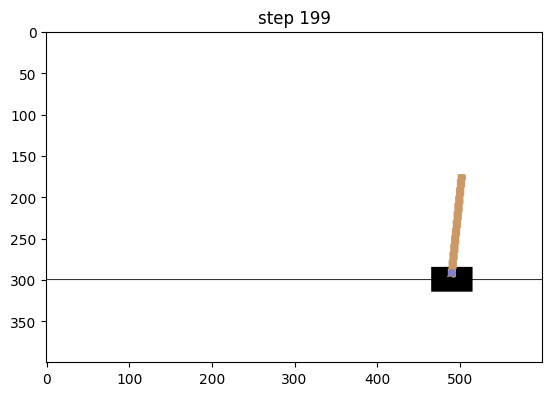

Finished with reward =  200.0


In [20]:
from IPython.display import clear_output
from itertools import count
from gym.wrappers import Monitor

total_reward = 0  # sum of rewards
test_env = loads(root_snapshot)  # env used to show progress
frames = []
for i in count():
    max_mean_val = -100
    best_child = None
    for child in root.children:
        if child.get_qvalue_estimate()> max_mean_val:
            max_mean_val = child.get_qvalue_estimate()
            best_child = child
    # ==================================== Your Code (Begin) ==================================
    
    # best_child = <select child with the highest mean reward>
        
    # ==================================== Your Code (End) ====================================

    # take action
    s, r, done, _ = test_env.step(best_child.action)

    # show image
    clear_output(True)
    plt.title("step %i" % i)
    rendered = test_env.render('rgb_array')
    frames.append(rendered)
    plt.imshow(rendered)
    plt.show()

    total_reward += r
    if done:
        print("Finished with reward = ", total_reward)
        break

    # discard unrealized part of the tree (because not every child matters :()
    for child in root.children:
        if child != best_child:
            child.safe_delete()

    # declare best child a new root
    root = Root.from_node(best_child)

    assert not root.is_leaf(), \
        "We ran out of tree! Need more planning! Try growing the tree right inside the loop."
    plan_mcts(root,n_iters=100)
create_video(frames)

## Notes


#### Assumptions

The full list of assumptions is:

* __Finite number of actions__: we enumerate all actions in `expand`.
* __Episodic (finite) MDP__: while technically it works for infinite MDPs, we perform a rollout for $10^4$ steps. If you are knowingly infinite, please adjust `t_max` to something more reasonable.
* __Deterministic MDP__: `Node` represents the single outcome of taking `self.action` in `self.parent`, and does not support the situation where taking an action in a state may lead to different rewards and next states.
* __No discounted rewards__: we assume $\gamma=1$. If that isn't the case, you only need to change two lines in `rollout()` and use `my_qvalue = self.immediate_reward + gamma * child_qvalue` for `propagate()`.
* __pickleable env__: won't work if e.g. your env is connected to a web-browser surfing the internet. For custom envs, you may need to modify get_snapshot/load_snapshot from `WithSnapshots`.

#### On `get_best_leaf` and `expand` functions

This MCTS implementation only selects leaf nodes for expansion.
This doesn't break things down because `expand` adds all possible actions. Hence, all non-leaf nodes are by design fully expanded and shouldn't be selected.

If you want to only add a few random action on each expand, you will also have to modify `get_best_leaf` to consider returning non-leafs.

#### Rollout policy

We use a simple uniform policy for rollouts. This introduces a negative bias to good situations that can be messed up completely with random bad action. As a simple example, if you tend to rollout with uniform policy, you better don't use sharp knives and walk near cliffs.

You can improve that by integrating a reinforcement _learning_ algorithm with a computationally light agent. You can even train this agent on optimal policy found by the tree search.